loading file vocab.json from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41/tokenizer.json
loading file chat_template.jinja from cache at None
ft

<class 'torch.Tensor'>
tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490, 897.0612, 876.6735,
        856.2857, 835.8979, 815.5102, 795.1224, 774.7347, 754.3469, 733.9592,
        713.5714, 693.1837, 672.7959, 652.4081, 632.0204, 611.6326, 591.2449,
        570.8571, 550.4694, 530.0816, 509.6939, 489.3061, 468.9184, 448.5306,
        428.1429, 407.7551, 387.3673, 366.9796, 346.5918, 326.2041, 305.8163,
        285.4286, 265.0408, 244.6531, 224.2653, 203.8775, 183.4898, 163.1020,
        142.7143, 122.3265, 101.9388,  81.5510,  61.1633,  40.7755,  20.3878,
          0.0000])
50
51


<ipython-input-2-18631420fe49>:69: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

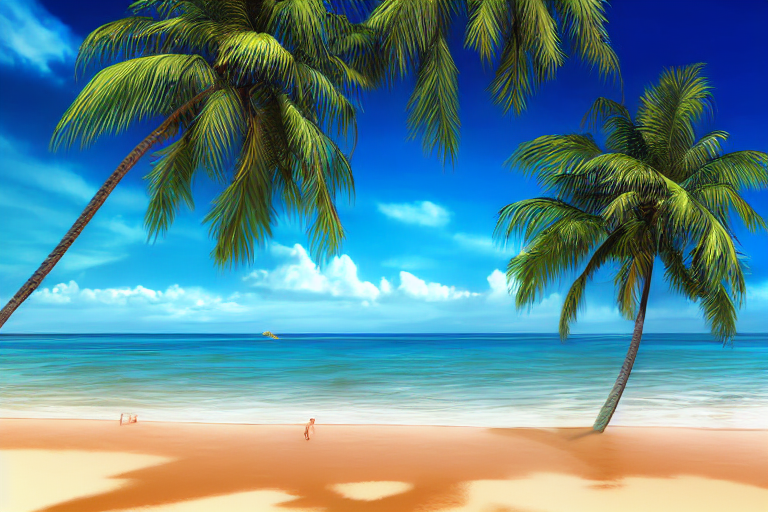

In [ ]:
!pip install transformers diffusers lpips accelerate
!pip install torch torchvision
!pip install diffusers[torch]
!pip install transformers
!pip install tqdm
!pip install pillow
!pip install matplotlib
!pip install ipython
!pip install numpy

import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms
torch_device = "cpu"
from transformers.utils import logging
logging.set_verbosity_info()

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)



tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")


text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")



unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)



scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)
prompt = ["View of a sea from the beach with palm trees around with humans swimming in the sea and clear sky. Overcast skies, high detail, ultra-realistic, cinematic, 4K, concept art style." ]
height = 512
width = 768
num_inference_steps = 50
guidance_scale = 7.5
generator = torch.manual_seed(4)
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
(batch_size, unet.in_channels, height // 8, width // 8),
generator=generator,
)

latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k
print(type(scheduler.timesteps))
print(scheduler.timesteps)
print(len(scheduler.timesteps))
print(len(scheduler.sigmas))

    # Loop
with autocast("cuda"):
    for t in tqdm(scheduler.timesteps):
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[(scheduler.timesteps == t).nonzero(as_tuple=True)[0].item()]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, t, latents)["prev_sample"]



# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents)


with torch.no_grad():
    decoded_output = vae.decode(latents)

# Extract the tensor from the decoder output
# Usually it is `sample` attribute, but confirm with your model's docs or print the output.
image_tensor = decoded_output.sample  # replace `.sample` with actual attribute if different

# Now process the tensor as usual
image = (image_tensor / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(img) for img in images]  # use img instead of image inside list comp
pil_images[0]

